In [419]:
! pip3 install pandas pycoingecko matplotlib scipy seaborn
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import datetime as dt
import time
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from tqdm import tqdm
from pycoingecko import CoinGeckoAPI
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.formula.api import ols
from statsmodels.formula.api import wls
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.filters.hp_filter import hpfilter
from pandas.plotting import lag_plot

In [420]:
data_dir = '../data/crypto/'
filename = 'bukele_btc_usd.csv'
tweet_date = "2018-07-18 01:58:00"
date_format = "%Y-%m-%d %H:%M:%S"
#tweet_datetime = pd.to_datetime(tweet_date,format=date_format)
tweet_datetime= pd.to_datetime("2021-09-07T05:57:00")

In [421]:
df = pd.read_csv(data_dir+filename)

In [422]:
def is_after_tweet(date,tweet_dt):
    if date < tweet_dt:
        return 0
    elif date > tweet_dt: 
        return 1
    else:
        pass
def days_since(date,tweet_dt):
    diff = date - tweet_dt
    return  diff.days + (diff.seconds / (3600 * 24))
def min_max(price,min_price,max_price):
    return (price - min_price)/(max_price-min_price)
def kernel(R,c,h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)
def gaussian_kernel(R,h,c=0):
    fraction = (1/(h*np.sqrt(2*np.pi)))
    exp = np.exp(-0.5*(((R-c)/h))**2)
    return fraction * exp

In [423]:
def gen_extra_cols(original_df,twt_dt,c=0,h=1):
    expanded_df = original_df.copy()
    expanded_df['before_after'] = expanded_df['date'].map(lambda x: is_after_tweet(x,twt_dt))
    expanded_df['days_since_tweet'] = expanded_df['date'].map(lambda x: days_since(x,twt_dt))
    expanded_df['min_max_prices'] = min_max(expanded_df['prices'],min(expanded_df['prices']),max(expanded_df['prices']))
    #expanded_df['kernel_weighting'] = expanded_df['days_since_tweet'].map(lambda x: kernel(x,c,h)) 
    #expanded_df['hp_prices'] = hp
    return expanded_df

In [424]:
df = df.astype({'date': 'datetime64[ns]'})

In [425]:
df = gen_extra_cols(df,tweet_datetime)

In [426]:
df

,prices,market_caps,total_volumes,timestamps,date,before_after,days_since_tweet,min_max_prices
0,13070.265333,2.421615e+11,2.151022e+10,1603779176623,2020-10-27 06:12:56.623,0,-314.988935,0.000272
1,13089.646908,2.425206e+11,2.158684e+10,1603782192402,2020-10-27 07:03:12.402,0,-314.954028,0.000621
2,13146.275972,2.435699e+11,2.171450e+10,1603785693143,2020-10-27 08:01:33.143,0,-314.913507,0.001640
3,13134.355398,2.433885e+11,2.100382e+10,1603789440756,2020-10-27 09:04:00.756,0,-314.870139,0.001425
4,13127.207366,2.432175e+11,2.102741e+10,1603793609674,2020-10-27 10:13:29.674,0,-314.821887,0.001297
...,...,...,...,...,...,...,...,...
15118,22395.365383,4.257567e+11,5.863673e+10,1658188891060,2022-07-19 00:01:31.060,1,314.753137,0.168035
15119,22403.439684,4.283181e+11,6.242972e+10,1658192502110,2022-07-19 01:01:42.110,1,314.794931,0.168180
15120,22109.908340,4.219811e+11,6.347940e+10,1658196148592,2022-07-19 02:02:28.592,1,314.837130,0.162900
15121,22076.855944,4.216078e+11,6.409420e+10,1658199673016,2022-07-19 03:01:13.016,1,314.877928,0.162305


In [404]:
def get_sub_df(original_df,twt_dt,window_size):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -window_size) & (sub_df['days_since_tweet'] <= window_size)].copy().reset_index(drop=True)
    return gen_extra_cols(sub_df,twt_dt)
def random_tweet_dt(original_df,window_size,asymmetry=False,d_bf=7,d_aft=2):
    if asymmetry:
        sample_from = original_df['date'][0] + dt.timedelta(days=d_bf)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=d_aft)
    else:
        sample_from = original_df['date'][0] + dt.timedelta(days=window_size)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=window_size)
    sampling_df = original_df[(original_df['date'] >= sample_from) & (original_df['date'] <= sample_to)]
    random_tweet = sampling_df.sample()
    random_tweet_date = original_df['date'][random_tweet.index.values.tolist()[0]]
    return random_tweet_date
def asymmetric_sub_df(original_df,twt_dt,days_before,days_after):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -days_before) & (sub_df['days_since_tweet'] <= days_after)]
    return gen_extra_cols(sub_df,twt_dt)

In [405]:
sub=get_sub_df(df,random_tweet_dt(df,1),1)

In [406]:
def multi_window_models(original_df,twt_dt,window_sizes=range(1,8),with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=6,d_aft=0,only_back=False,only_forward=False):
    models = []
    names = []
    for w in window_sizes:
        if asymmetry:
            if only_back:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft)
            elif only_forward:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf,d_aft+w)
            else:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft+w)
        else:
            window_df = get_sub_df(original_df,twt_dt,w)
            
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        window_df,
                        weights=kernel(window_df['days_since_tweet'],c=0,h=w)).fit()
        elif with_gaussian:
            if asymmetry:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                            window_df,
                            weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(d_bf+w)/2)).fit()
            else:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                           window_df,
                           weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(w/2))).fit()
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',window_df).fit()
                            
        models.append(model)
        if asymmetry:
            if only_back:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft) + ' Days')
            elif only_forward:
                names.append('- ' + str(d_bf) + ' + ' + str(d_aft+w) + ' Days')
            else:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft+w) + ' Days')
        else:
            names.append('± ' + str(w) + ' Days')
    return models, names
def multi_regression_tbl(models,names):
    return summary_col(
        models,
        stars=True,
        float_format='%0.3f',
        model_names=names,
        info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))})

In [407]:
models,names = multi_window_models(df,tweet_datetime,window_sizes=range(1,13))
results_table = multi_regression_tbl(models,names)
results_table

,± 1 Days,± 2 Days,± 3 Days,± 4 Days,± 5 Days,± 6 Days,± 7 Days,± 8 Days,± 9 Days,± 10 Days,± 11 Days,± 12 Days
Intercept,0.969***,0.995***,0.946***,0.905***,0.886***,0.908***,0.925***,0.903***,0.864***,0.826***,0.809***,0.811***
,(0.034),(0.026),(0.023),(0.017),(0.014),(0.013),(0.011),(0.011),(0.012),(0.012),(0.012),(0.011)
days_since_tweet,0.196***,0.184***,0.129***,0.076***,0.065***,0.076***,0.078***,0.069***,0.056***,0.044***,0.039***,0.039***
,(0.058),(0.022),(0.013),(0.007),(0.005),(0.004),(0.003),(0.002),(0.002),(0.002),(0.002),(0.002)
before_after,-0.070,-0.336***,-0.454***,-0.393***,-0.409***,-0.472***,-0.472***,-0.506***,-0.531***,-0.531***,-0.533***,-0.559***
,(0.047),(0.037),(0.033),(0.024),(0.020),(0.018),(0.015),(0.016),(0.018),(0.018),(0.017),(0.016)
days_since_tweet:before_after,-1.310***,-0.549***,-0.283***,-0.189***,-0.155***,-0.143***,-0.136***,-0.104***,-0.068***,-0.044***,-0.033***,-0.028***
,(0.081),(0.032),(0.019),(0.010),(0.007),(0.005),(0.004),(0.003),(0.003),(0.003),(0.003),(0.002)
R-squared,0.903,0.854,0.798,0.832,0.851,0.844,0.857,0.800,0.701,0.638,0.616,0.602
R-squared Adj.,0.899,0.852,0.796,0.830,0.850,0.843,0.857,0.800,0.700,0.637,0.615,0.601


In [408]:
asym_models,asym_names = multi_window_models(df,tweet_datetime,asymmetry=True,with_gaussian=True,d_bf=0,d_aft=0)
asym_tbl = multi_regression_tbl(asym_models,asym_names)
asym_tbl

,- 1 + 1 Days,- 2 + 2 Days,- 3 + 3 Days,- 4 + 4 Days,- 5 + 5 Days,- 6 + 6 Days,- 7 + 7 Days
Intercept,0.994***,0.981***,0.967***,0.935***,0.912***,0.909***,0.918***
,(0.028),(0.024),(0.022),(0.017),(0.015),(0.013),(0.011)
days_since_tweet,0.262***,0.166***,0.147***,0.098***,0.080***,0.077***,0.076***
,(0.063),(0.027),(0.017),(0.010),(0.007),(0.005),(0.004)
before_after,-0.028,-0.236***,-0.385***,-0.383***,-0.401***,-0.433***,-0.434***
,(0.038),(0.034),(0.031),(0.024),(0.021),(0.018),(0.015)
days_since_tweet:before_after,-1.568***,-0.661***,-0.391***,-0.243***,-0.192***,-0.164***,-0.147***
,(0.087),(0.039),(0.024),(0.014),(0.009),(0.007),(0.005)
R-squared,0.897,0.835,0.783,0.786,0.802,0.810,0.825
R-squared Adj.,0.893,0.833,0.781,0.784,0.801,0.809,0.824


In [412]:
def perform_placebos(original_df,window_size=7,n=100,with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=7,d_aft=2):
    models = []
    for i in tqdm (range(n),desc="Performing placebos..."):
        rand_twt_dt = random_tweet_dt(original_df,window_size,asymmetry,d_bf,d_aft)
        if asymmetry:
            rand_window_df = asymmetric_sub_df(original_df,rand_twt_dt,d_bf,d_aft)
        else:
            rand_window_df = get_sub_df(original_df,rand_twt_dt,window_size)
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=kernel(rand_window_df['days_since_tweet'],c=0,h=window_size)).fit()
        if with_gaussian:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=gaussian_kernel(rand_window_df['days_since_tweet'],c=0,h=(d_bf/2))).fit()
            
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',rand_window_df).fit()   
        models.append(model)
    return models

In [430]:
placebos = perform_placebos(df,n=5000)

Performing placebos...: 100%|██████████| 5000/5000 [11:25<00:00,  7.30it/s]


In [431]:
placebo_coeffs = pd.Series(placebos).map(lambda x: x.params['before_after']).to_list()

0.24327529728893824
0.2432996284684049
0.0034407763430035336


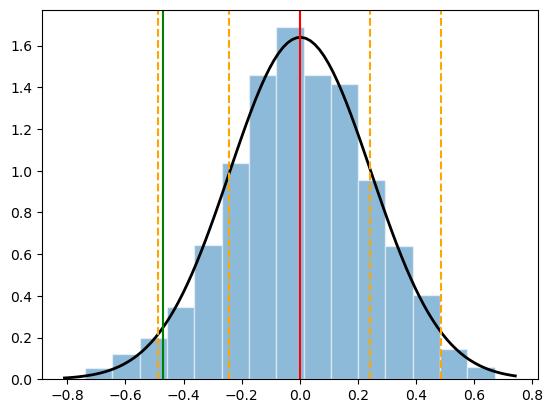

In [435]:
plt.hist(placebo_coeffs,alpha=0.5,bins=15,edgecolor='white',density=True)
mean_coeffs = stats.mean(placebo_coeffs)

mu, se = norm.fit(placebo_coeffs)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,se)
plt.plot(x,p,'k',linewidth=2)

plt.axvline(-0.472,color='green')
plt.axvline(mean_coeffs,color='red')
plt.axvline(se,color='orange',linestyle='--')
plt.axvline(2*se,color='orange',linestyle='--')
plt.axvline(-se,color='orange',linestyle='--')
plt.axvline(-2*se,color='orange',linestyle='--')


diff=abs(mu-mean_coeffs)
print(se)
print(std)
print(std/np.sqrt(5000))

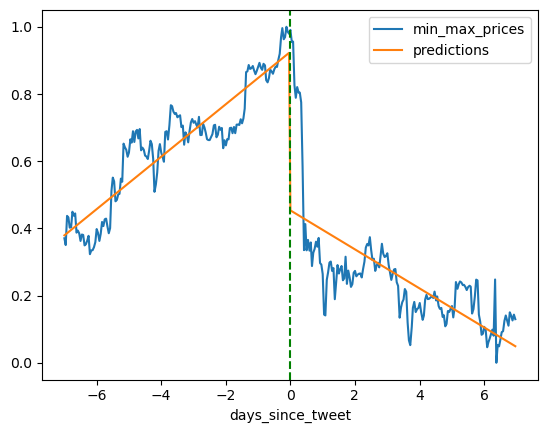

In [428]:
seven_days = get_sub_df(df,tweet_datetime,7)
seven_day_model = ols('min_max_prices ~ days_since_tweet * before_after',seven_days).fit()
ax = seven_days.plot(y='min_max_prices',x='days_since_tweet')
seven_days.assign(predictions=seven_day_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')

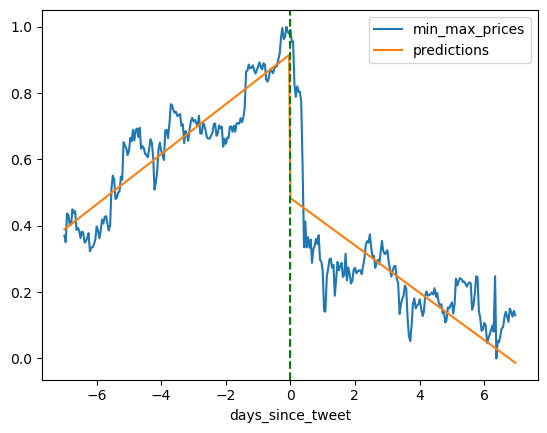

In [429]:
seven_day_w_model = wls('min_max_prices ~ days_since_tweet * before_after',seven_days,weights=gaussian_kernel(seven_days['days_since_tweet'],c=0,h=3.5)).fit()
ax_w = seven_days.plot(y='min_max_prices',x='days_since_tweet')
seven_days.assign(predictions=seven_day_w_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax_w,color='C1')
plt.axvline(0,color='green',linestyle='--')

In [299]:
seven_day_w_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         min_max_prices   R-squared:                       0.825
Model:                            WLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     520.0
Date:                Thu, 29 Dec 2022   Prob (F-statistic):          4.63e-125
Time:                        21:26:11   Log-Likelihood:                 227.21
No. Observations:                 336   AIC:                            -446.4
Df Residuals:                     332   BIC:                            -431.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.9177      0.016     58.795      0.000       0.887       0.948
days_since_tweet                  0.0755      0.005     14.944      0.000       0.066       0.085
before_after                     -0.4342      0.022    -19.780      0.000      -0.477      -0.391
days_since_tweet:before_after    -0.1468      0.007    -20.593      0.000      -0.161      -0.133
==============================================================================
Omnibus:                      180.711   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1604.616
Skew:                           2.066   Prob(JB):                         0.00
Kurtosis:                      12.877   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

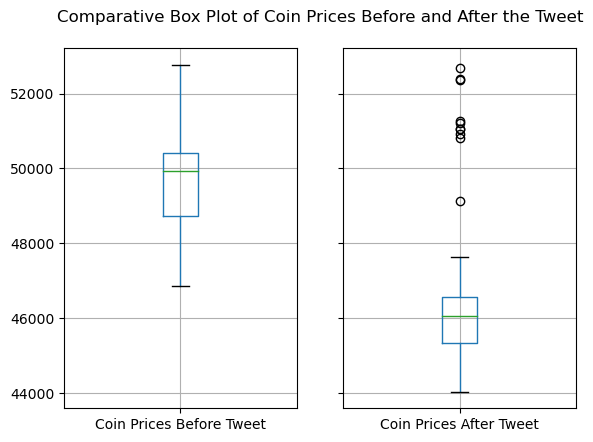

In [331]:
def before_after_box_plot(original_df):
    axes=original_df.groupby(by='before_after').boxplot(column='prices',subplots=True)
    axes[0].set_title('')
    axes[1].set_title('')
    plt.suptitle('Comparative Box Plot of Coin Prices Before and After the Tweet')
    axes[0].set_xticklabels(['Coin Prices Before Tweet'])
    axes[1].set_xticklabels(['Coin Prices After Tweet'])
    return axes
before_after_box_plot(seven_days)

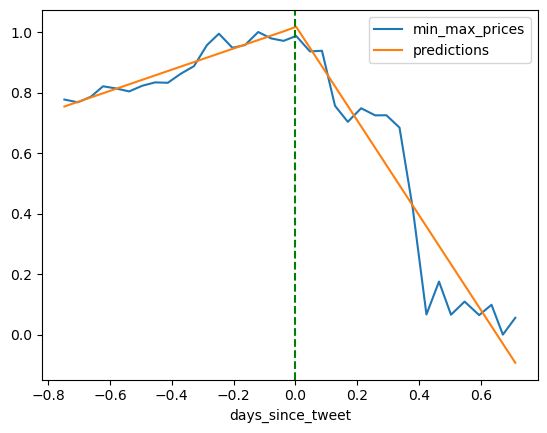

In [330]:
one_day = get_sub_df(df,tweet_datetime,0.75)
one_day_model = ols('min_max_prices ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='min_max_prices',x='days_since_tweet',kind="line")
one_day.assign(predictions=one_day_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')

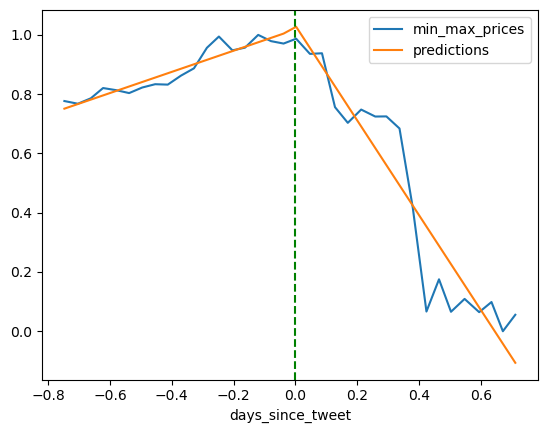

In [303]:
one_day_w_model = wls('min_max_prices ~ days_since_tweet * before_after',one_day,weights=gaussian_kernel(one_day['days_since_tweet'],c=0,h=0.5)).fit()
ax_w1 = one_day.plot(y='min_max_prices',x='days_since_tweet')
one_day.assign(predictions=one_day_w_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax_w1,color='C1')
plt.axvline(0,color='green',linestyle='--')

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

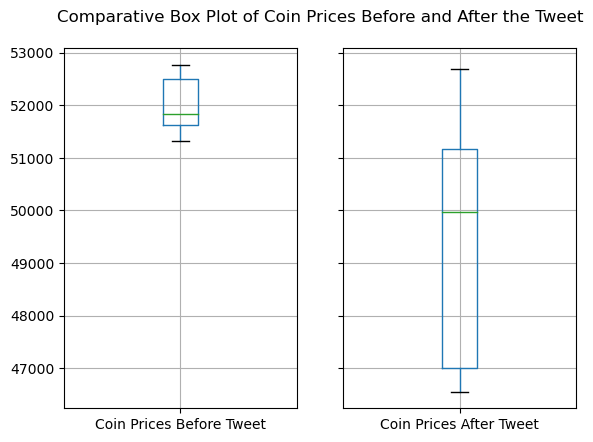

In [329]:
before_after_box_plot(one_day)

In [306]:
prices_cycle, prices_trend = hpfilter(seven_days['prices'],lamb=50)

<AxesSubplot:>

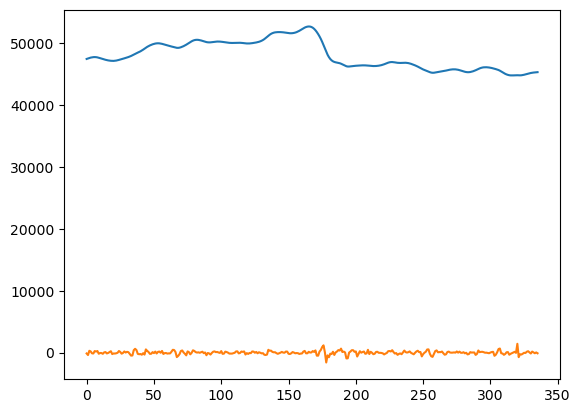

In [307]:
prices_trend.plot()
prices_cycle.plot()

In [308]:
one_day['hp_min_max'] = hpfilter(one_day['min_max_prices'],lamb=10)[1]

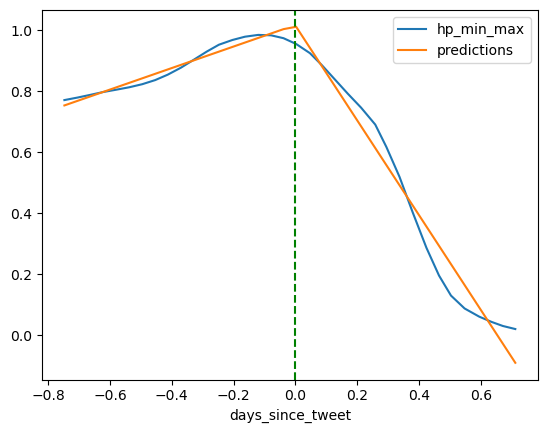

In [309]:
one_day_hp_m = ols('hp_min_max ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='hp_min_max',x='days_since_tweet')
one_day.assign(predictions=one_day_hp_m.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')

In [310]:
one_day_hp_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hp_min_max   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     555.0
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           1.17e-27
Time:                        21:26:13   Log-Likelihood:                 60.736
No. Observations:                  36   AIC:                            -113.5
Df Residuals:                      32   BIC:                            -107.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.0176      0.023     43.928      0.000       0.970       1.065
days_since_tweet                  0.3529      0.052      6.816      0.000       0.247       0.458
before_after                     -0.0023      0.032     -0.073      0.943      -0.067       0.062
days_since_tweet:before_after    -1.9067      0.073    -26.099      0.000      -2.055      -1.758
==============================================================================
Omnibus:                        1.308   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                0.460
Skew:                          -0.155   Prob(JB):                        0.795
Kurtosis:                       3.458   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [311]:
one_day_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         min_max_prices   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     154.8
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           3.97e-19
Time:                        21:26:13   Log-Likelihood:                 37.667
No. Observations:                  36   AIC:                            -67.33
Df Residuals:                      32   BIC:                            -61.00
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.0157      0.044     23.099      0.000       0.926       1.105
days_since_tweet                  0.3503      0.098      3.565      0.001       0.150       0.550
before_after                      0.0053      0.060      0.088      0.931      -0.117       0.128
days_since_tweet:before_after    -1.9172      0.139    -13.826      0.000      -2.200      -1.635
==============================================================================
Omnibus:                       10.253   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.388
Skew:                          -0.659   Prob(JB):                     0.000751
Kurtosis:                       5.803   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
seven_day_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         min_max_prices   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     665.4
Date:                Thu, 29 Dec 2022   Prob (F-statistic):          5.21e-140
Time:                        21:26:13   Log-Likelihood:                 299.45
No. Observations:                 336   AIC:                            -590.9
Df Residuals:                     332   BIC:                            -575.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.9255      0.015     59.862      0.000       0.895       0.956
days_since_tweet                  0.0781      0.004     20.485      0.000       0.071       0.086
before_after                     -0.4718      0.022    -21.656      0.000      -0.515      -0.429
days_since_tweet:before_after    -0.1361      0.005    -25.257      0.000      -0.147      -0.126
==============================================================================
Omnibus:                      162.594   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1016.279
Skew:                           1.941   Prob(JB):                    2.08e-221
Kurtosis:                      10.585   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='days_since_tweet'>

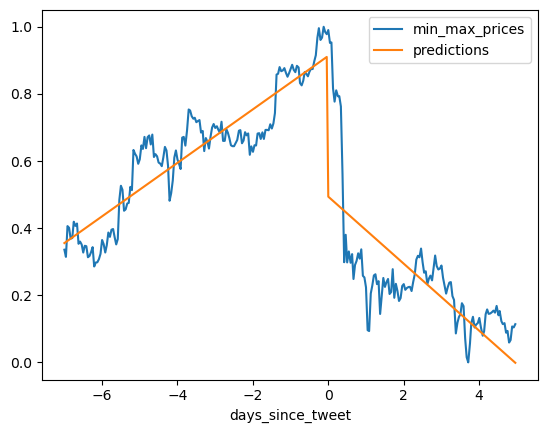

In [328]:
asymmetric_df = asymmetric_sub_df(df,tweet_datetime,7,5)
asym_model = wls('min_max_prices ~ days_since_tweet * before_after',asymmetric_df,weights=gaussian_kernel(asymmetric_df['days_since_tweet'],c=0,h=3.5)).fit()
ax = asymmetric_df.plot(y='min_max_prices',x='days_since_tweet')
asymmetric_df.assign(predictions=asym_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
#plt.axvline(0,color='green',linestyle='--')

In [326]:
asym_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         min_max_prices   R-squared:                       0.821
Model:                            WLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     434.2
Date:                Thu, 29 Dec 2022   Prob (F-statistic):          9.77e-106
Time:                        21:51:31   Log-Likelihood:                 189.70
No. Observations:                 288   AIC:                            -371.4
Df Residuals:                     284   BIC:                            -356.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.9132      0.017     53.687      0.000       0.880       0.947
days_since_tweet                  0.0797      0.006     14.472      0.000       0.069       0.091
before_after                     -0.4191      0.025    -16.567      0.000      -0.469      -0.369
days_since_tweet:before_after    -0.1795      0.009    -19.309      0.000      -0.198      -0.161
==============================================================================
Omnibus:                      118.585   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              707.983
Skew:                           1.564   Prob(JB):                    1.83e-154
Kurtosis:                      10.015   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""